# ARIMA

## Zasada działania

In [2]:
import pandas as pd

In [3]:
data = pd.read_csv("../data/mg.dat", sep=" ", index_col=0, names=["y"])
data["ds"] = pd.date_range(start="01-01-2000", periods=data.shape[0], freq="D")

# Model

[Opis](https://medium.com/@er.iit.pradeep09/time-series-forecasting-using-arima-caa84d52463b)

In [4]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from math import sqrt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

%matplotlib inline

In [12]:
test_df = data.loc[data.index >= 901].copy()
train_df =  data.loc[data.index < 901].copy()

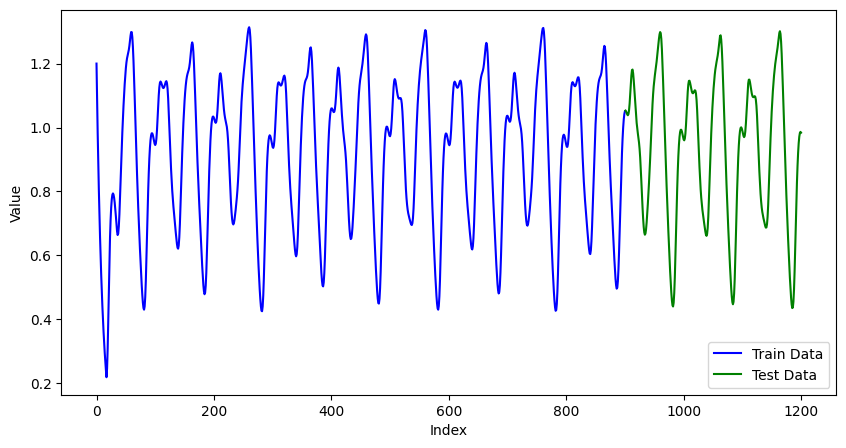

In [13]:
plt.figure(figsize=(10, 5))
plt.plot(train_df.index, train_df.y, label="Train Data", color='blue')
plt.plot(test_df.index, test_df.y, label="Test Data", color='green')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.show()

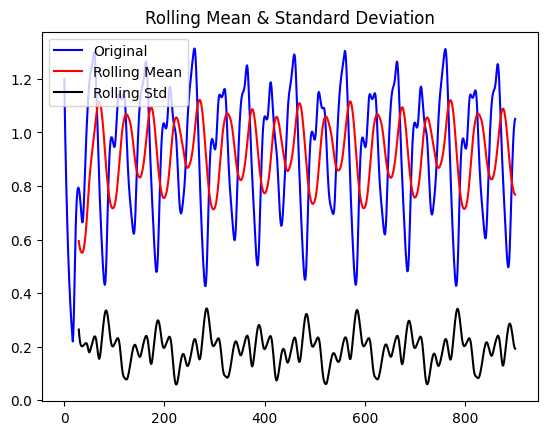

Results of Dickey-Fuller Test:
ADF Statistic: -8.136167849656012
p-value: 1.0578055898567502e-12
Critical Values:
	1%: -3.4378113191216397
	5%: -2.8648337072350074
	10%: -2.5685238062308366


In [16]:
def check_stationarity(timeseries):
    
    # rolling statistics
    rolling_mean = timeseries.rolling(window=30).mean()
    rolling_std = timeseries.rolling(window=30).std()
    
    # rolling statistics plot
    original = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Dickey–Fuller test:
    result = adfuller(timeseries, autolag='AIC')
    print('Results of Dickey-Fuller Test:')
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

timeseries = train_df.y
check_stationarity(timeseries)

Z testu wynika, że szereg jest stacjonarny (p-value < 0.05). Gdyby tak nie było trzeba by dokonać transformacji, aby do takiego doprowadzić, wykonujemy metodę `.diff()` na danych, może wielokrotnie. Pozwala to zbadać jaki powinien być hiperparametr `d`. Dla przykładu poniżej analiza jednokrotnego `diff`. Tutaj `diff` nie jest potrzebny więc `d` = 0.

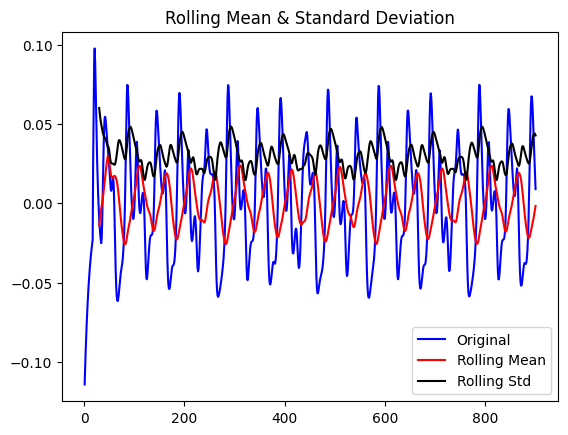

Results of Dickey-Fuller Test:
ADF Statistic: -6.905464568617435
p-value: 1.250572105397213e-09
Critical Values:
	1%: -3.437819842246547
	5%: -2.8648374649929753
	10%: -2.5685258078777093


In [18]:
def check_stationarity(timeseries):
    
    # rolling statistics
    rolling_mean = timeseries.rolling(window=30).mean()
    rolling_std = timeseries.rolling(window=30).std()
    
    # rolling statistics plot
    original = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Dickey–Fuller test:
    result = adfuller(timeseries, autolag='AIC')
    print('Results of Dickey-Fuller Test:')
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

timeseries = train_df.y.diff()
check_stationarity(timeseries.dropna())

In [21]:
def plot_pacf_acf(timeseries):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,7))
    plot_acf(timeseries.dropna(), lags=40, ax=ax1)
    plot_pacf(timeseries.dropna(), lags=40, ax=ax2)
    plt.show()

Teraz sprawdzimy `ACF` i `PACF` aby dobrać hiperparametry `p` i `q`.

/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


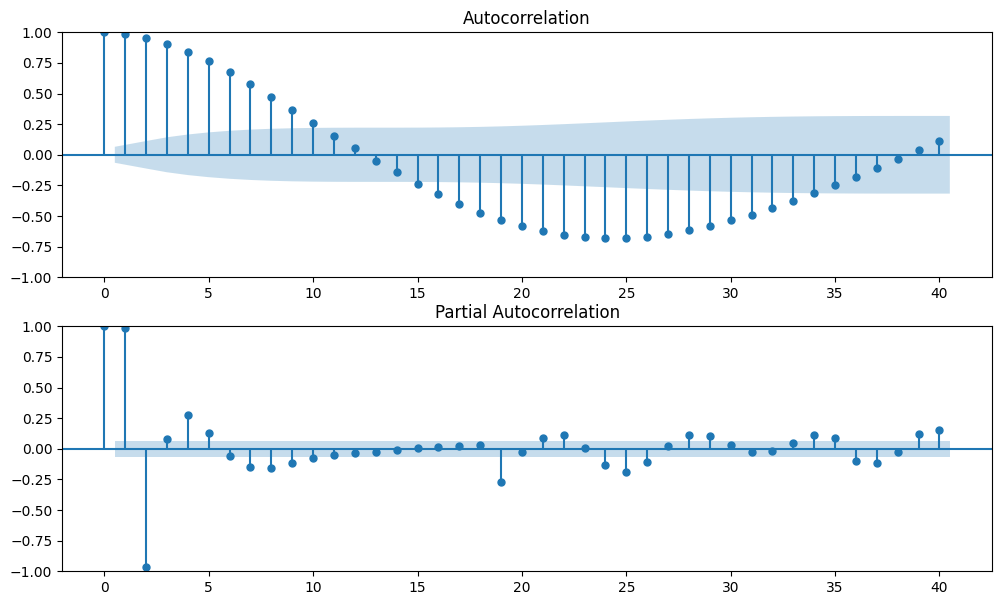

In [22]:
plot_pacf_acf(train_df.y)

Na podstawie wykresów można wyestymować `p` = 3 i `q` = 10.

/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  901
Model:                ARIMA(3, 0, 10)   Log Likelihood                4229.149
Date:                Sun, 02 Apr 2023   AIC                          -8428.297
Time:                        15:44:29   BIC                          -8356.245
Sample:                             0   HQIC                         -8400.774
                                - 901                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9086      0.032     28.697      0.000       0.847       0.971
ar.L1          2.8015      0.022    126.992      0.000       2.758       2.845
ar.L2         -2.6356      0.045    -58.114      0.0

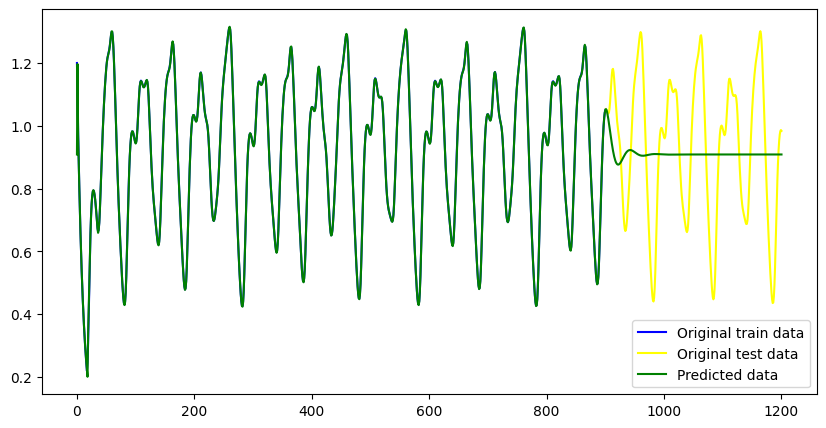

In [25]:
def run_model(model_params, train, test):
    model = ARIMA(train, order = model_params)
    model_fit = model.fit()
    print(model_fit.summary())
    predictions = model_fit.predict(start=train.index[0], end=train.index[-1] + test.shape[0]).to_frame()
    rmse = sqrt(mean_squared_error(test, predictions.predicted_mean[train.index[-1] + 1:]))
    print("RSME:", rmse)
    plt.figure(figsize=(10, 5))
    plt.plot(train.index, train, color='blue', label='Original train data')
    plt.plot(test.index, test, color='yellow', label='Original test data')
    plt.plot(list(train.index) + list(test.index), predictions.predicted_mean, color='green', label='Predicted data')
    plt.legend()
    plt.show()

# model_params = (p, d, q)
train = train_df.y.copy()
test = test_df.y.copy()

run_model((3,0,10), train, test)

Wynik nie jest najciekawszy, dlatego należy poszukać najlepszych parametrów dla modelu

In [26]:
p_params = [1, 2, 3, 4]
d_params = [0,1,2]
q_params = [1,3,5,7,9,11]
best_rmse = np.inf
best_params = None
result_val = []
train = train_df.y.copy()
test = test_df.y.copy()

for p_val in p_params:
    for d_val in d_params:
        for q_val in q_params:
            model = ARIMA(train, order = (p_val, d_val, q_val))
            model_fit = model.fit()
            predictions = model_fit.predict(start=train.index[0], end=train.index[-1] + test.shape[0]).to_frame()
            rmse = sqrt(mean_squared_error(test, predictions.predicted_mean[train.index[-1] + 1:]))
            print(f"{p_val=} {d_val=} {q_val=} --- {rmse=}")
            result_val.append((rmse, (p_val, d_val, q_val)))
            if rmse <= best_rmse:
                best_rmse = rmse
                best_params = (p_val, d_val, q_val)

print(f"{best_params=}")

/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p_val=1 d_val=0 q_val=1 --- rmse=0.23497341586654785


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p_val=1 d_val=0 q_val=3 --- rmse=0.22995322128033838
p_val=1 d_val=0 q_val=5 --- rmse=0.22767940668098277


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p_val=1 d_val=0 q_val=7 --- rmse=0.22830914335493646


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p_val=1 d_val=0 q_val=9 --- rmse=0.22824095067410077


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p_val=1 d_val=0 q_val=11 --- rmse=0.2283960059744274


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p_val=1 d_val=1 q_val=1 --- rmse=0.3411761570890557


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p_val=1 d_val=1 q_val=3 --- rmse=0.2630519537767908
p_val=1 d_val=1 q_val=5 --- rmse=0.23786931202472508


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p_val=1 d_val=1 q_val=7 --- rmse=0.23589759045623887


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p_val=1 d_val=1 q_val=9 --- rmse=0.2318677868454701


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p_val=1 d_val=1 q_val=11 --- rmse=0.24846381732584363
p_val=1 d_val=2 q_val=1 --- rmse=6.4401606863812
p_val=1 d_val=2 q_val=3 --- rmse=2.383764371919243
p_val=1 d_val=2 q_val=5 --- rmse=2.651378581710182


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p_val=1 d_val=2 q_val=7 --- rmse=17.574395069986327


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p_val=1 d_val=2 q_val=9 --- rmse=0.2543292876179992
p_val=1 d_val=2 q_val=11 --- rmse=10.729040934042636
p_val=2 d_val=0 q_val=1 --- rmse=0.23022180781966567


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p_val=2 d_val=0 q_val=3 --- rmse=0.23100447737764412
p_val=2 d_val=0 q_val=5 --- rmse=0.23109579883122144


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p_val=2 d_val=0 q_val=7 --- rmse=0.23079643607906944


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p_val=2 d_val=0 q_val=9 --- rmse=0.21586448019141405


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p_val=2 d_val=0 q_val=11 --- rmse=0.21195614978078728
p_val=2 d_val=1 q_val=1 --- rmse=0.2304539880131539
p_val=2 d_val=1 q_val=3 --- rmse=0.23396139785943756
p_val=2 d_val=1 q_val=5 --- rmse=0.2321529375667259


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p_val=2 d_val=1 q_val=7 --- rmse=0.23700811906785207
p_val=2 d_val=1 q_val=9 --- rmse=0.23040590064897212


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p_val=2 d_val=1 q_val=11 --- rmse=0.23483958086178652


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p_val=2 d_val=2 q_val=1 --- rmse=3.6599138600615815
p_val=2 d_val=2 q_val=3 --- rmse=1.268326143662397
p_val=2 d_val=2 q_val=5 --- rmse=2.0325985730970713


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p_val=2 d_val=2 q_val=7 --- rmse=1.2700140712843382


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p_val=2 d_val=2 q_val=9 --- rmse=2.2613680486031353


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p_val=2 d_val=2 q_val=11 --- rmse=2.4962657274168185


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p_val=3 d_val=0 q_val=1 --- rmse=0.6782498597035826


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p_val=3 d_val=0 q_val=3 --- rmse=0.23072329356320834
p_val=3 d_val=0 q_val=5 --- rmse=0.23380808080272336


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p_val=3 d_val=0 q_val=7 --- rmse=0.23115403755997074


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p_val=3 d_val=0 q_val=9 --- rmse=0.22751901054618615


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p_val=3 d_val=0 q_val=11 --- rmse=0.22872560734532316


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p_val=3 d_val=1 q_val=1 --- rmse=0.2331721766877772
p_val=3 d_val=1 q_val=3 --- rmse=0.24504310482584496


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: User

p_val=3 d_val=1 q_val=5 --- rmse=0.24742581617640097
p_val=3 d_val=1 q_val=7 --- rmse=0.23172599202758767


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p_val=3 d_val=1 q_val=9 --- rmse=0.4314052954633842


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p_val=3 d_val=1 q_val=11 --- rmse=0.3895815708850513


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p_val=3 d_val=2 q_val=1 --- rmse=2.0451307227683007


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p_val=3 d_val=2 q_val=3 --- rmse=1.3678611155511833
p_val=3 d_val=2 q_val=5 --- rmse=2.0387926523139006


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p_val=3 d_val=2 q_val=7 --- rmse=0.6262663245978977


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p_val=3 d_val=2 q_val=9 --- rmse=0.7920262745810976


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p_val=3 d_val=2 q_val=11 --- rmse=1.4589933128673869


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p_val=4 d_val=0 q_val=1 --- rmse=0.24094574156411033


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p_val=4 d_val=0 q_val=3 --- rmse=0.22096976859393527
p_val=4 d_val=0 q_val=5 --- rmse=0.2069416293958344


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p_val=4 d_val=0 q_val=7 --- rmse=0.2142639813920789


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p_val=4 d_val=0 q_val=9 --- rmse=0.21600880376454631


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p_val=4 d_val=0 q_val=11 --- rmse=0.21921904672215314


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p_val=4 d_val=1 q_val=1 --- rmse=0.23181970687278042
p_val=4 d_val=1 q_val=3 --- rmse=2.0287979741365487


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p_val=4 d_val=1 q_val=5 --- rmse=0.24860322652129294
p_val=4 d_val=1 q_val=7 --- rmse=0.4439388574399592


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p_val=4 d_val=1 q_val=9 --- rmse=0.38923285665444884


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p_val=4 d_val=1 q_val=11 --- rmse=0.22829440247648858
p_val=4 d_val=2 q_val=1 --- rmse=1.3428641838438216
p_val=4 d_val=2 q_val=3 --- rmse=1.5000434790651267
p_val=4 d_val=2 q_val=5 --- rmse=2.02026655518898


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p_val=4 d_val=2 q_val=7 --- rmse=1.9123776553439793


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


p_val=4 d_val=2 q_val=9 --- rmse=1.261153953665376


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p_val=4 d_val=2 q_val=11 --- rmse=2.58915773574455
best_params=(4, 0, 5)


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  901
Model:                 ARIMA(4, 0, 5)   Log Likelihood                4249.245
Date:                Sun, 02 Apr 2023   AIC                          -8476.491
Time:                        15:56:26   BIC                          -8423.652
Sample:                             0   HQIC                         -8456.307
                                - 901                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9158      0.017     53.556      0.000       0.882       0.949
ar.L1          3.5918      0.058     61.770      0.000       3.478       3.706
ar.L2         -4.9509      0.169    -29.348      0.0

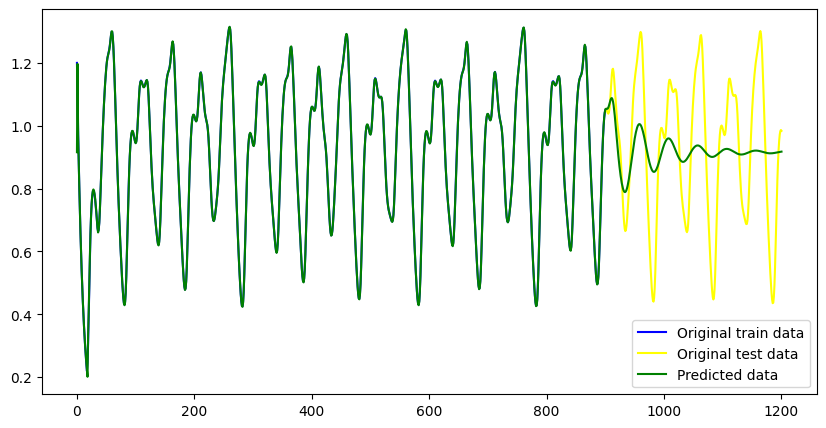

In [27]:
run_model(best_params, train, test)

## Porównanie dla kilku zbiorów danych

In [38]:
from statsmodels.tsa.arima.model import ARIMA

### Mackey Glass

In [16]:
data = pd.read_csv("../data/mg.dat", sep=" ", index_col=0, names=["y"])
data["ds"] = pd.date_range(start="01-01-2000", periods=data.shape[0], freq="D")

In [17]:
test_df = data.loc[data.index >= 701].copy()
train_df =  data.loc[data.index < 701].copy()

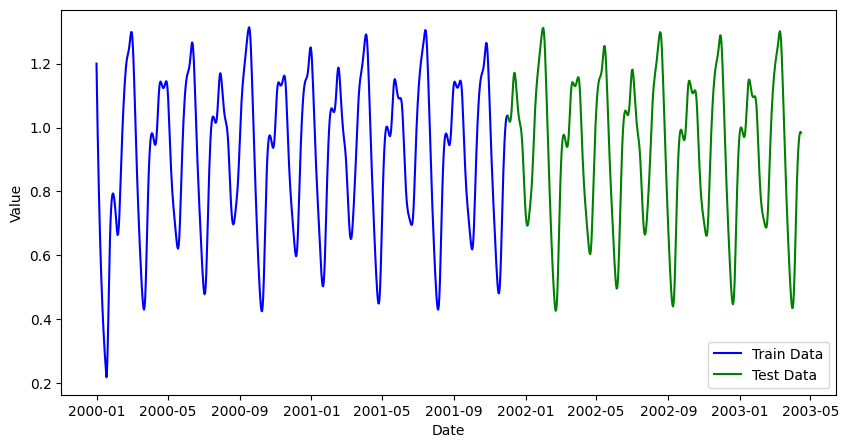

In [37]:
plt.figure(figsize=(10, 5))
plt.plot(train_df.ds, train_df.y, label="Train Data", color='blue')
plt.plot(test_df.ds, test_df.y, label="Test Data", color='green')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

In [19]:
p_params = [1, 3, 4, 5]
d_params = [0, 1, 2]
q_params = [1, 3, 5, 7]
best_rmse = np.inf
best_params = None
result_val = []
train = train_df.y.copy()
test = test_df.y.copy()

for p_val in p_params:
    for d_val in d_params:
        for q_val in q_params:
            model = ARIMA(train, order = (p_val, d_val, q_val))
            model_fit = model.fit()
            predictions = model_fit.predict(start=train.index[0], end=train.index[-1] + test.shape[0]).to_frame()
            rmse = sqrt(mean_squared_error(test, predictions.predicted_mean[train.index[-1] + 1:]))
            print(f"{p_val=} {d_val=} {q_val=} --- {rmse=}")
            result_val.append((rmse, (p_val, d_val, q_val)))
            if rmse <= best_rmse:
                best_rmse = rmse
                best_params = (p_val, d_val, q_val)

print(f"{best_params=}")

/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p_val=1 d_val=0 q_val=1 --- rmse=0.23204355103715738


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p_val=1 d_val=0 q_val=3 --- rmse=0.23012636185245203
p_val=1 d_val=0 q_val=5 --- rmse=0.22711024961296508


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p_val=1 d_val=0 q_val=7 --- rmse=0.2274978175703823


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p_val=1 d_val=0 q_val=9 --- rmse=0.22753146563550128


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p_val=1 d_val=0 q_val=11 --- rmse=0.22758579440146293


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p_val=1 d_val=1 q_val=1 --- rmse=0.23670785614514075


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p_val=1 d_val=1 q_val=3 --- rmse=0.23041959524154984
p_val=1 d_val=1 q_val=5 --- rmse=0.228148467044469


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p_val=1 d_val=1 q_val=7 --- rmse=0.22737972484205463


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p_val=1 d_val=1 q_val=9 --- rmse=0.22730793419199746
p_val=1 d_val=1 q_val=11 --- rmse=0.234121576785806
p_val=1 d_val=2 q_val=1 --- rmse=9.591467737779777
p_val=1 d_val=2 q_val=3 --- rmse=4.202195683662453
p_val=1 d_val=2 q_val=5 --- rmse=4.940752323963226


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p_val=1 d_val=2 q_val=7 --- rmse=26.454211079402384


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p_val=1 d_val=2 q_val=9 --- rmse=0.5324619097871054
p_val=1 d_val=2 q_val=11 --- rmse=0.41308310386665187
p_val=2 d_val=0 q_val=1 --- rmse=0.23050121587642913


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p_val=2 d_val=0 q_val=3 --- rmse=0.23017625365404906
p_val=2 d_val=0 q_val=5 --- rmse=0.2301595224099983


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p_val=2 d_val=0 q_val=7 --- rmse=0.23033842640118576
p_val=2 d_val=0 q_val=9 --- rmse=0.22159741687802112


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p_val=2 d_val=0 q_val=11 --- rmse=0.21881437352707073


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p_val=2 d_val=1 q_val=1 --- rmse=0.22860430835712317
p_val=2 d_val=1 q_val=3 --- rmse=0.23072944461851408
p_val=2 d_val=1 q_val=5 --- rmse=0.2294401794396075


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p_val=2 d_val=1 q_val=7 --- rmse=0.23748500685100224
p_val=2 d_val=1 q_val=9 --- rmse=0.2312042071486565


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p_val=2 d_val=1 q_val=11 --- rmse=0.23528716792189353
p_val=2 d_val=2 q_val=1 --- rmse=5.174861213936621
p_val=2 d_val=2 q_val=3 --- rmse=0.6705831285767194
p_val=2 d_val=2 q_val=5 --- rmse=2.201932668024652


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p_val=2 d_val=2 q_val=7 --- rmse=1.0964980427928115


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p_val=2 d_val=2 q_val=9 --- rmse=2.304818936541423


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p_val=2 d_val=2 q_val=11 --- rmse=3.805049494317733


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p_val=3 d_val=0 q_val=1 --- rmse=0.3316921238467133
p_val=3 d_val=0 q_val=3 --- rmse=0.2293218894741423
p_val=3 d_val=0 q_val=5 --- rmse=0.23084169441716754


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p_val=3 d_val=0 q_val=7 --- rmse=0.2292445763009125


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p_val=3 d_val=0 q_val=9 --- rmse=0.2275352756925612


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p_val=3 d_val=0 q_val=11 --- rmse=0.2275956290980054
p_val=3 d_val=1 q_val=1 --- rmse=0.23133109314861677


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p_val=3 d_val=1 q_val=3 --- rmse=0.2350801428185758


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p_val=3 d_val=1 q_val=5 --- rmse=0.23107778032785176
p_val=3 d_val=1 q_val=7 --- rmse=0.22913275889456916


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p_val=3 d_val=1 q_val=9 --- rmse=0.48659813857746137


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p_val=3 d_val=1 q_val=11 --- rmse=0.3342253306463958
p_val=3 d_val=2 q_val=1 --- rmse=1.5707850337429712


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p_val=3 d_val=2 q_val=3 --- rmse=0.9340688088217979
p_val=3 d_val=2 q_val=5 --- rmse=2.1821810817690483


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


p_val=3 d_val=2 q_val=7 --- rmse=3.7521712117914774
p_val=3 d_val=2 q_val=9 --- rmse=1.9274886061174648


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p_val=3 d_val=2 q_val=11 --- rmse=1.25194275247006


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p_val=4 d_val=0 q_val=1 --- rmse=0.5863576310284297
p_val=4 d_val=0 q_val=3 --- rmse=0.22583619847284828
p_val=4 d_val=0 q_val=5 --- rmse=0.2177864458236976


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p_val=4 d_val=0 q_val=7 --- rmse=0.2230513774862204


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p_val=4 d_val=0 q_val=9 --- rmse=0.22425532722671068


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p_val=4 d_val=0 q_val=11 --- rmse=0.22404321638949357


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p_val=4 d_val=1 q_val=1 --- rmse=0.2297626135463774


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p_val=4 d_val=1 q_val=3 --- rmse=0.23004963378890003


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p_val=4 d_val=1 q_val=5 --- rmse=0.23438950996922878


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p_val=4 d_val=1 q_val=7 --- rmse=0.4326739820996081


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p_val=4 d_val=1 q_val=9 --- rmse=1.059787717719861


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p_val=4 d_val=1 q_val=11 --- rmse=0.2312685745924298
p_val=4 d_val=2 q_val=1 --- rmse=0.7149724041987271
p_val=4 d_val=2 q_val=3 --- rmse=1.0542494926025916
p_val=4 d_val=2 q_val=5 --- rmse=2.158351953587183


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p_val=4 d_val=2 q_val=7 --- rmse=1.1432199162801744


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


p_val=4 d_val=2 q_val=9 --- rmse=0.2526100359735279


/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p_val=4 d_val=2 q_val=11 --- rmse=1.0790634623677102
best_params=(4, 0, 5)


In [20]:
model = ARIMA(train_df["y"], order=best_params)
model_fit = model.fit()
print(model_fit.summary())
forecast = model_fit.predict(start=data.index[0], end=data.index[-1]).to_frame()

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  701
Model:                 ARIMA(4, 0, 5)   Log Likelihood                3238.165
Date:                Fri, 07 Apr 2023   AIC                          -6454.330
Time:                        13:41:14   BIC                          -6404.253
Sample:                             0   HQIC                         -6434.974
                                - 701                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9230      0.021     44.121      0.000       0.882       0.964
ar.L1          3.5807      0.074     48.231      0.000       3.435       3.726
ar.L2         -4.9157      0.215    -22.817      0.0

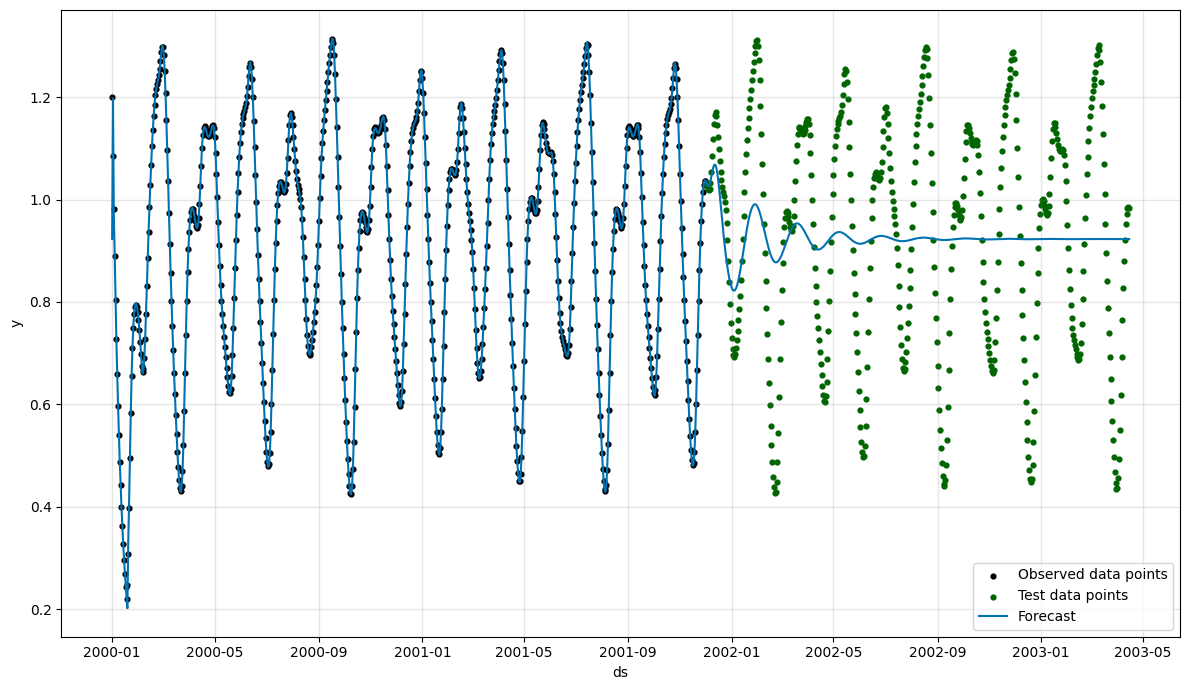

In [36]:
fig = plt.figure(facecolor='w', figsize=(12, 7))
ax = fig.add_subplot(111)
ax.scatter(train_df["ds"], train_df["y"], color="black", label='Observed data points', s=12)
ax.scatter(test_df["ds"], test_df["y"], color="darkgreen", label='Test data points', s=12)
ax.plot(data["ds"], forecast["predicted_mean"], color="#0072B2", label='Forecast')
ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
ax.set_xlabel("ds")
ax.set_ylabel("y")
ax.legend()
fig.tight_layout()
plt.show()


10 days horizon - rmse = 0.0432
50 days horizon - rmse = 0.0891
100 days horizon - rmse = 0.1872
200 days horizon - rmse = 0.1995
300 days horizon - rmse = 0.2085


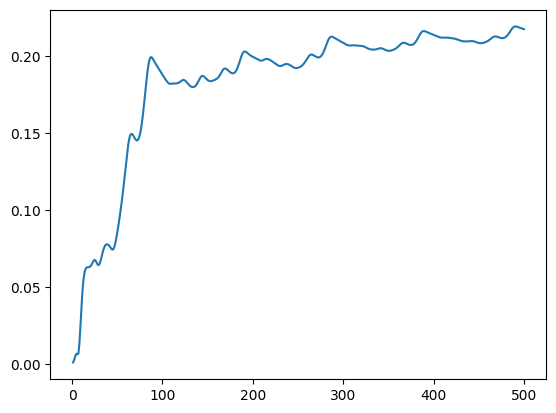

In [22]:
se = (forecast.loc[test_df.index]["predicted_mean"] - test_df["y"]) ** 2
predicted_days = np.arange(1, se.shape[0]+1)
rmse = np.sqrt(np.cumsum(se) / predicted_days).values

for h in [10, 50, 100, 200, 300]:
    print(f"{h} days horizon - rmse = {round(rmse[h], 4)}")

plt.plot(predicted_days, rmse)
plt.show()

### Sunspots

### Electricity